In [77]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Input, LSTM, Bidirectional, Dense, TimeDistributed, RepeatVector
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption
from tools import to_timeseries
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
SEQUENCE_SIZE = 64
BATCH_SIZE = 2048

# Data

In [69]:
dataset = load_household_power_consumption(hour_one_hot=True)
data_x, data_y = split_x_y(dataset)

list(data_x[:, 0])

2017-08-22 21:59:20,296 [hybrid-lstm.tool | INFO] Load existing dataset


[0.0,
 0.0,
 0.084000000000000005,
 0.084000000000000005,
 0.085999999999999993,
 0.085999999999999993,
 0.088000000000000009,
 0.088000000000000009,
 0.088000000000000009,
 0.088000000000000009,
 0.085999999999999993,
 0.08199999999999999,
 0.08199999999999999,
 0.070000000000000007,
 0.062,
 0.062,
 0.064000000000000001,
 0.059999999999999998,
 0.059999999999999998,
 0.064000000000000001,
 0.064000000000000001,
 0.062,
 0.064000000000000001,
 0.064000000000000001,
 0.064000000000000001,
 0.066000000000000003,
 0.045999999999999999,
 0.075999999999999998,
 0.075999999999999998,
 0.078,
 0.048000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.080000000000000002,
 0.078,
 0.075999999999999998,
 0.075999999999999998,
 0.075999999999999998,
 0.078,
 0.078,
 0.0,
 0.062,
 0.062,
 0.066000000000000003,
 0.066000000000000003,
 0.066000000000000003,
 0.064000000000000001,
 0.064000000000000001,
 0.066000000000000003,
 0.064000000000000001,
 0.066000000000000003,
 0.0680000000

In [3]:
dataset = load_household_power_consumption(hour_one_hot=True)
data_x, data_y = split_x_y(dataset)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(
    to_timeseries(data_x[:-SEQUENCE_SIZE], True, t=SEQUENCE_SIZE), 
    to_timeseries(data_y[SEQUENCE_SIZE:], t=SEQUENCE_SIZE), 
    train_ratio=0.8)

print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-22 21:15:17,764 [hybrid-lstm.tool | INFO] Load existing dataset


data_x: (43642, 31)
data_y: (43642, 1)
train_x: (34812, 64, 30)
train_y: (34812, 64, 1)
test_x: (8703, 64, 30)
test_y: (8703, 64, 1)


# Models

In [64]:
d = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2]

np.convolve(d, np.ones(4), mode='same')/4

array([ 0.75,  1.5 ,  2.5 ,  3.5 ,  4.5 ,  5.5 ,  6.5 ,  7.5 ,  8.5 ,
        7.25,  5.25])

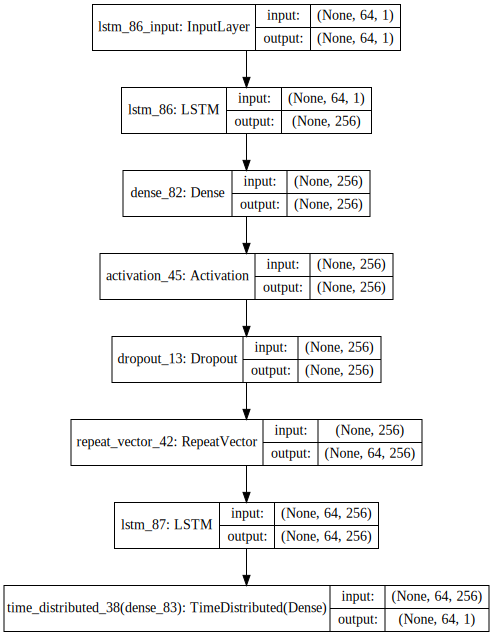

In [87]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1=256, d1=256, drop1=0.3, l2=256, n_input=30, n_output=64):
    np.random.seed(0)
    model = Sequential()
    
    # Encoder
    model.add(LSTM(l1, input_shape=(SEQUENCE_SIZE, n_input)))
    model.add(Dense(d1))
    model.add(Activation('selu'))
    if drop1:
        model.add(Dropout(drop1))
    
    # Decoder
    model.add(RepeatVector(n_output))
    model.add(LSTM(l2, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', r2])
    return model
    
    
model = create_model(l1=256, d1=256, l2=256, n_input=1)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [ ]:
model = create_model(l1=256, d1=256, drop1=0.3, l2=256, n_input=30)

history = History()
model.fit(train_x, train_y, epochs=9, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34812 samples, validate on 8703 samples
Epoch 1/9


In [76]:
model = create_model(l1=256, d1=256, drop1=0.3, l2=256, n_input=30)

history = History()
model.fit(train_x, train_y, epochs=50, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34812 samples, validate on 8703 samples
Epoch 1/50
10s - loss: 0.0246 - acc: 4.4884e-07 - r2: -1.2595e+00 - val_loss: 0.0060 - val_acc: 1.1490e-04 - val_r2: 0.2995
Epoch 2/50
7s - loss: 0.0077 - acc: 0.0000e+00 - r2: 0.2839 - val_loss: 0.0055 - val_acc: 1.1490e-04 - val_r2: 0.3106
Epoch 3/50
7s - loss: 0.0070 - acc: 0.0000e+00 - r2: 0.3543 - val_loss: 0.0055 - val_acc: 1.1490e-04 - val_r2: 0.3208
Epoch 4/50
7s - loss: 0.0067 - acc: 0.0000e+00 - r2: 0.3787 - val_loss: 0.0052 - val_acc: 1.1490e-04 - val_r2: 0.3740
Epoch 5/50
7s - loss: 0.0065 - acc: 0.0000e+00 - r2: 0.3966 - val_loss: 0.0051 - val_acc: 1.1490e-04 - val_r2: 0.3858
Epoch 6/50
7s - loss: 0.0063 - acc: 0.0000e+00 - r2: 0.4159 - val_loss: 0.0049 - val_acc: 1.1490e-04 - val_r2: 0.4179
Epoch 7/50
7s - loss: 0.0061 - acc: 4.4884e-07 - r2: 0.4382 - val_loss: 0.0047 - val_acc: 1.1490e-04 - val_r2: 0.4433
Epoch 8/50
7s - loss: 0.0059 - acc: 4.4884e-07 - r2: 0.4569 - val_loss: 0.0047 - val_acc: 1.1490e-04 - val_r2: 0.4316
E

KeyboardInterrupt: 

# Evaluation

In [40]:
%time eval_results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

CPU times: user 588 ms, sys: 128 ms, total: 716 ms
Wall time: 682 ms
loss: 0.004660405273658731
acc: 0.0001149029070435482
r2: 0.42148672175601914


[77  ] r^2: -4.15       
[6537] r^2: -0.2091     
[1795] r^2: -4.934      
[7407] r^2: -2.055      
[8633] r^2: -0.1273     
[8659] r^2: -0.5728     
[705 ] r^2: 0.3739      
[4358] r^2: -0.1638     
[4944] r^2: -8.567      
[533 ] r^2: -0.1786     
[4924] r^2: -2.562      
[1487] r^2: -95.8       
[2554] r^2: -0.143      
[5678] r^2: -0.0985     
[5186] r^2: -4.543      
[7266] r^2: -0.7092     


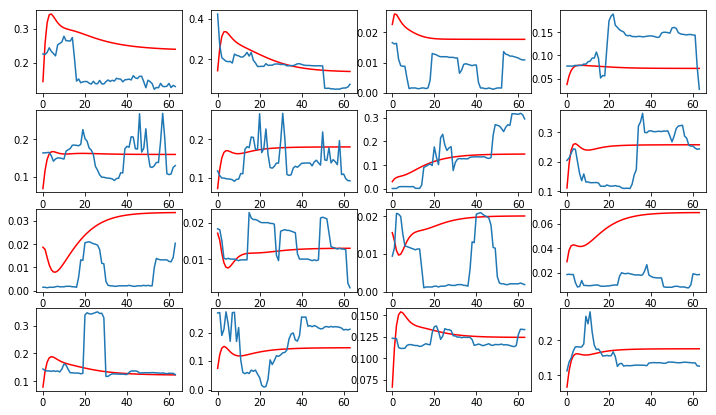

In [85]:
vis_evaluate(model, test_x, test_y, batch=2048)